## Mars Photogrammetry Preprocessing Pipeline

By Christian Tate, Cornell University; Ithaca, NY



In [1]:
# Import python modules

import numpy as np
import cv2, glob, time, os
import matplotlib.pyplot as plt
# from planetaryimage import PDS3Image
# import colour_demosaicing
# from PIL import Image
# import matplotlib.cm as cm
# from scipy import interpolate
# from scipy.spatial.transform import Rotation as R
# import colour_demosaicing
import pandas as pd

%run MPPP.py
%matplotlib inline

In [2]:
file_extension = ''

'''
future work: save these calibration prameters as a text files, which we load for each camera
'''

# save images and thereby overwrite existing images
save_im    = 1

# add an alpha channel to the output images
save_mask  = 1

# add transparrent pixels to restore the image's full, standard size
pad_im     = 1
pad_im_z   = 1

# turn on when finding the waypoint offsets
find_offsets_mode = 0

# set the color values
gamma      = 2.2      # gamma value
gamma      = 2        # gamma value

# fraction of the dynamic range to clip off the lower values of image 
clip_low_z = 0.02  # for the Mastcam-Z cameras
clip_low   = 0.1   # for everything else


# scale all the scale parameters below bsy the same number
scale_scale = 18

# color balance parameters for the Mars 2020 science cameras
scale_z,  scale_red_z,  scale_blue_z  = [ 0.9*scale_scale, 0.7 , 1.5  ] # Mastcam-Z 
scale_l,  scale_red_l,  scale_blue_l  = [ 1.0*scale_scale, 0.75, 1.40 ] # SuperCam RMI
scale_s,  scale_red_s,  scale_blue_s  = [ 1.0*scale_scale, 0.85, 1.40 ] # SHERLOC WATSON 

# color balance parameters for the Mars 2020 engineering cameras
scale_n,  scale_red_n,  scale_blue_n  = [ 1.0*scale_scale, 0.75, 1.2  ] # Navcam
scale_f,  scale_red_f,  scale_blue_f  = [ 1.1*scale_scale, 0.78, 1.25 ] # Front Hazcam
scale_r,  scale_red_r,  scale_blue_r  = [ 1.1*scale_scale, 0.78, 1.25 ] # Rear Hazcam
scale_v,  scale_red_v,  scale_blue_v  = [ 1.1*scale_scale, 1.12, 0.92 ] # Grayscale VCE Navcam
scale_hr, scale_red_hr, scale_blue_hr = [ 1.0*scale_scale, 0.75, 1.43 ] # Inginuity RTE
scale_hn, scale_red_hn, scale_blue_hn = [ 1.0*scale_scale, 1.1 , 0.92 ] # Inginuity Navcam


In [10]:
# Set input path to IMG files and search criteria


directory_input = 'Z:/Mastcam-Z/agisoft/data/datadrive'
# directory_input = 'C:/Users/cornell/Desktop/data/zcam'
path_input      = directory_input
# path_input      = 'C:/Users/cornell/Desktop/data/*/data/sol/*/rdr/*'  # engineering cameras
# path_input      = 'C:/Users/cornell/Desktop/data/datadrive/*/ids/rdr/*'  # engineering cameras
# path_input    = 'C:/Users/cornell/Desktop/data/*/data/*/rad/*'        # science cameras

# directory_input = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020'
# path_input    = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020/mars2020_*_ops_calibrated/data/sol/00477/ids/rdr/*'  # engineering cameras
# path_input    = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020/mars2020_mastcamz_sci_calibrated/data/*/rad'    # science cameras

# Set output path
directory_output = 'Z:/Mastcam-Z/agisoft/images'
# directory_output = 'C:/Users/cornell/Desktop'
# directory_output = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/images' 

pre = '*MV05'
suf = 'refs_vce_500s'

# pre = '*_070'
# suf = 'refs_700s'

# pre = 'Z*0_04'
# suf = 'zcam_400s'

# pre = 'Z*0_0'
# suf = 'zcam_refs'

sequ_id = ''

IMG_paths = [] \
          + ( glob.glob(  path_input + '/' +pre+'*R*_N*'+sequ_id+'*.IMG' ) ) 

print( len(IMG_paths), 'images\n')
# IMG_paths

891 images



In [11]:
%%time

%run MPPP.py


pos_lines  = []
error_lines= []
rover_xyzs = []
im_xyzs    = []
rover_rots = []
im_azs     = []
im_els     = []
sols       = []
rmcs       = []
ims        = []
im_save_path  = ''

print( len(IMG_paths), 'images\n')


for i in range(len(IMG_paths))[::1][:]:
    
    if 1:
#     try:    # catch all the images that fail to process
        
        # open image
        im = image( IMG_paths[i] )
        print( i, im.filename )
        
        # Set color processing parameters
        im.scale       = scale_scale
        im.scale_red   = 1
        im.scale_blue  = 1
        im.clip_low    = clip_low
        im.gamma       = gamma
        im.pad_im      = pad_im
        im.save_im     = save_im
        im.save_mask   = save_mask
        im.find_offsets_mode = find_offsets_mode

        # Mars 2020 Mastcam-Z
        if im.cam[0] == 'Z':
            im.scale       = scale_z
            im.scale_red   = scale_red_z
            im.scale_blue  = scale_blue_z
            im.clip_low    = clip_low_z
            im.pad_im      = pad_im_z

        # Mars 2020 SHERLOC WATSON
        if im.cam[0] == 'S':
            im.scale       = scale_s
            im.scale_red   = scale_red_s
            im.scale_blue  = scale_blue_s

        # Mars 2020 SuperCam RMI
        if im.cam[0] == 'L':
            im.scale       = scale_l
            im.scale_red   = scale_red_l
            im.scale_blue  = scale_blue_l

        # Mars 2020 Navcam
        if im.cam[0] == 'N':
            im.scale       = scale_n
            im.scale_red   = scale_red_n
            im.scale_blue  = scale_blue_n

        # Mars 2020 Navcam VCE images
        if 'MV0' in im.IMG_path:
            im.scale       = scale_v
            im.scale_red   = scale_red_v
            im.scale_blue  = scale_blue_v
            im.clip_low    = 0.1

        # Mars 2020 Front Hazcam
        if im.cam[0] == 'F':
            im.scale       = scale_f
            im.scale_red   = scale_red_f
            im.scale_blue  = scale_blue_f
            im.clip_low    = clip_low/2

        # Mars 2020 Rear Hazcam
        if im.cam[0] == 'R':
            im.scale       = scale_r
            im.scale_red   = scale_red_r
            im.scale_blue  = scale_blue_r
            im.clip_low    = clip_low/2

        # Heli Ingenuity RTE 
        if im.filename[0:3] == 'HSF':
            im.scale       = scale_hr
            im.scale_red   = scale_red_hr
            im.scale_blue  = scale_blue_hr

        # Heli Ingenuity Navcam  
        if im.filename[0:3] == 'HNM':
            im.scale       = scale_hn
            im.scale_red   = scale_red_hn
            im.scale_blue  = scale_blue_hn
        
        # create save directory
        im.save_path_full = make_save_path( im.IMG_path, directory_output, fullpath=True, file_extension = '.png'  ) 
        im.save_path      = make_save_path( im.IMG_path, directory_output, fullpath=False ) 
        im.save_name      = im.save_path_full.split('/')[-1]
        csv_save_path     = im.save_path
        
        # process and save image
        if im.save_im:
            
            im.image_process( )

            if im.save_mask:
                im.im8a = cv2.cvtColor( im.im8, cv2.COLOR_BGR2RGBA )
                im.im8a[:,:,3] = im.mask_im
                cv2.imwrite( im.save_path_full, im.im8a )                
            else:
                cv2.imwrite( im_save_path_full, im.im8[:,:,::-1] )  

        
        # find image position and rotation parameters
        im.image_reference( )

        # save reference data for plotting        
        '''
        future work: replace these lists with pandas dataframes
        '''
        im_xyzs   .append( [ im.X, im.Y, im.Z ] )
        rover_xyzs.append( [ im.X_offset, im.Y_offset, im.Z_offset ] )
        rover_rots.append( im.rot_rover )
        im_azs    .append( im.az )
        im_els    .append( im.el )
        rmcs      .append( im.label['ROVER_MOTION_COUNTER'])
        sols      .append( int(im.label['LOCAL_TRUE_SOLAR_TIME_SOL']) )
        
        # create a line for the reference file
        # Label	 X/East	Y/North	Z/Altitude	Yaw	Pitch	Roll
        pos_line =  im.save_name+'\t'\
                     +str( np.round( im.X,4))+'\t'\
                     +str( np.round( im.Y,4))+'\t'\
                     +str( np.round( im.Z,4))+'\t'\
                     +str( np.round( im.az,2))+'\t'\
                     +str( np.round( im.el,2))+'\t'\
                     +str( np.round( im.rl,2))+'\n'

        if im.filename[0]!='S':
            pos_lines.append( pos_line )

        try:
            print( 'sol {} site {} drive {}  zenith angle {:0.0f} scale {:0.2f}'.
                        format( im.sol, im.site, im.drive, im.el*57.3, im.ftau ) )
        except:
            print( 'sol {} site {} drive {}'.
                        format( im.sol, im.site, im.drive, ) )
        print( '', i, pos_line[:], )
        print( )

#     except:
#         print( im.filename, 'failed to process! \n' )
#         error_lines.append( im.IMG_path +'\n' )


current_time = time.strftime("%Y%m%d-%H%M%S")


#save failed images list as TXT
if len(error_lines) > 0:
    csv_save_path = im.save_path+'/failed_'+suf+'_'+current_time+'.txt'
    with open(csv_save_path,'w') as file:
        for error_line in error_lines:
            file.write(error_line)

            
#save image positions as CSV file
csv_save_path = im.save_path+'/positions_'+suf+'_'+current_time+ '.txt'
with open(csv_save_path,'w') as file:
    for pos_line in pos_lines:
        file.write(pos_line)


len( pos_lines )

891 images

0 NLMV0548_0715592846_074RZS_N0265162VCE_15900_0A02LLJ01.IMG
sol 548 site 26 drive 5162  zenith angle 3493 scale 0.68
 0 NLMV0548_0715592846_074RZS_N0265162VCE_15900_0A02LLJ01.png	-2585.3223	334.1202	30.7814	197.23	60.96	0


1 NLMV0548_0715592846_074RZS_N0265162VCE_15900_0A02LLJ02.IMG
sol 548 site 26 drive 5162  zenith angle 3493 scale 0.68
 1 NLMV0548_0715592846_074RZS_N0265162VCE_15900_0A02LLJ02.png	-2585.3223	334.1202	30.7814	197.23	60.96	0


2 NLMV0548_0715592980_541RZS_N0265167VCE_15900_0A02LLJ02.IMG
sol 548 site 26 drive 5167  zenith angle 3250 scale 0.68
 2 NLMV0548_0715592980_541RZS_N0265167VCE_15900_0A02LLJ02.png	-2586.7383	329.3185	30.9527	190.44	56.72	0


3 NLMV0548_0715593114_934RZS_N0265174VCE_15900_0A02LLJ02.IMG
sol 548 site 26 drive 5174  zenith angle 3324 scale 0.68
 3 NLMV0548_0715593114_934RZS_N0265174VCE_15900_0A02LLJ02.png	-2587.6682	325.5678	31.1046	201.97	58.01	0


4 NLMV0548_0715593351_802RZS_N0265203VCE_15900_0A02LLJ02.IMG
sol 548 site 26 drive 5203 

sol 555 site 26 drive 5433  zenith angle 3264 scale 0.68
 36 NLMV0555_0716206808_651RZS_N0265433VCE_16000_0A02LLJ01.png	-2615.4398	322.7321	33.535	315.88	56.96	0


37 NLMV0555_0716206839_246RZS_N0265439VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5439  zenith angle 3118 scale 0.68
 37 NLMV0555_0716206839_246RZS_N0265439VCE_15900_0A02LLJ01.png	-2614.8399	322.745	33.4957	345.83	54.42	0


38 NLMV0555_0716206898_258RZS_N0265449VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5449  zenith angle 2933 scale 0.68
 38 NLMV0555_0716206898_258RZS_N0265449VCE_16000_0A02LLJ01.png	-2614.0017	323.5409	33.3359	15.15	51.19	0


39 NLMV0555_0716206925_646RZS_N0265451VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5451  zenith angle 2911 scale 0.68
 39 NLMV0555_0716206925_646RZS_N0265451VCE_16000_0A02LLJ01.png	-2613.7075	324.5612	33.2126	10.75	50.8	0


40 NLMV0555_0716206959_323RZS_N0265457VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5457  zenith angle 2962 scale 0.68
 40 NLMV0555_0716206959_323RZS_N0265457V

73 NLMV0555_0716208570_693RZS_N0265665VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5665  zenith angle 3385 scale 0.71
 73 NLMV0555_0716208570_693RZS_N0265665VCE_15900_0A02LLJ01.png	-2610.5792	337.2639	32.0688	159.55	59.08	0


74 NLMV0555_0716208631_177RZS_N0265671VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5671  zenith angle 3483 scale 0.71
 74 NLMV0555_0716208631_177RZS_N0265671VCE_16000_0A02LLJ01.png	-2610.4145	335.4123	32.1754	174.46	60.79	0


75 NLMV0555_0716208669_667RZS_N0265673VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5673  zenith angle 3369 scale 0.71
 75 NLMV0555_0716208669_667RZS_N0265673VCE_16000_0A02LLJ01.png	-2610.2372	334.411	32.1966	175.16	58.8	0


76 NLMV0555_0716208706_226RZS_N0265677VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5677  zenith angle 3325 scale 0.71
 76 NLMV0555_0716208706_226RZS_N0265677VCE_16000_0A02LLJ01.png	-2610.4448	333.4764	32.2182	189.76	58.02	0


77 NLMV0555_0716208737_396RZS_N0265679VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5679  zeni

sol 555 site 26 drive 5847  zenith angle 3457 scale 0.72
 109 NLMV0555_0716210263_027RZS_N0265847VCE_15900_0A02LLJ01.png	-2644.5322	327.4558	35.6704	262.38	60.33	0


110 NLMV0555_0716210296_308RZS_N0265853VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5853  zenith angle 3309 scale 0.72
 110 NLMV0555_0716210296_308RZS_N0265853VCE_16000_0A02LLJ01.png	-2645.5957	327.4288	35.6689	264.96	57.75	0


111 NLMV0555_0716210351_692RZS_N0265858VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5858  zenith angle 3366 scale 0.72
 111 NLMV0555_0716210351_692RZS_N0265858VCE_16000_0A02LLJ01.png	-2646.4669	327.4247	35.7423	263.79	58.74	0


112 NLMV0555_0716210378_802RZS_N0265863VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5863  zenith angle 3484 scale 0.72
 112 NLMV0555_0716210378_802RZS_N0265863VCE_16000_0A02LLJ01.png	-2647.4179	327.4451	35.8051	265.45	60.81	0


113 NLMV0555_0716210405_929RZS_N0265865VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5865  zenith angle 3556 scale 0.72
 113 NLMV0555_0716210405_92

sol 555 site 26 drive 6033  zenith angle 3481 scale 0.72
 145 NLMV0555_0716211493_305RZS_N0266033VCE_16000_0A02LLJ01.png	-2677.0445	329.1908	38.3405	270.31	60.76	0


146 NLMV0555_0716211526_309RZS_N0266039VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6039  zenith angle 3514 scale 0.72
 146 NLMV0555_0716211526_309RZS_N0266039VCE_16000_0A02LLJ01.png	-2678.034	329.268	38.4227	269.63	61.33	0


147 NLMV0555_0716211564_352RZS_N0266045VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6045  zenith angle 3490 scale 0.72
 147 NLMV0555_0716211564_352RZS_N0266045VCE_16000_0A02LLJ01.png	-2679.0254	329.3491	38.4811	269.57	60.91	0


148 NLMV0555_0716211598_601RZS_N0266051VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6051  zenith angle 3480 scale 0.72
 148 NLMV0555_0716211598_601RZS_N0266051VCE_16000_0A02LLJ01.png	-2680.0187	329.4349	38.5447	269.88	60.73	0


149 NLMV0555_0716211631_386RZS_N0266057VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6057  zenith angle 3491 scale 0.72
 149 NLMV0555_0716211631_386R

sol 555 site 26 drive 6219  zenith angle 3704 scale 0.71
 181 NLMV0555_0716212736_997RZS_N0266219VCE_16000_0A02LLJ01.png	-2711.1114	330.0991	41.6612	253.38	64.64	0


182 NLMV0555_0716212767_398RZS_N0266223VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6223  zenith angle 3504 scale 0.71
 182 NLMV0555_0716212767_398RZS_N0266223VCE_16000_0A02LLJ01.png	-2712.1438	329.8847	41.7266	258.04	61.15	0


183 NLMV0555_0716212817_366RZS_N0266224VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6224  zenith angle 3486 scale 0.71
 183 NLMV0555_0716212817_366RZS_N0266224VCE_16000_0A02LLJ01.png	-2713.0808	329.7693	41.8117	261.44	60.84	0


184 NLMV0555_0716212845_867RZS_N0266229VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6229  zenith angle 3514 scale 0.71
 184 NLMV0555_0716212845_867RZS_N0266229VCE_15900_0A02LLJ01.png	-2714.0207	329.6603	41.9017	263.27	61.33	0


185 NLMV0555_0716212872_789RZS_N0266231VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6231  zenith angle 3419 scale 0.71
 185 NLMV0555_0716212872_78

sol 555 site 26 drive 6381  zenith angle 3496 scale 0.68
 217 NLMV0555_0716215203_430RZS_N0266381VCE_16000_0A02LLJ01.png	-2742.2049	332.922	43.9533	276.97	61.0	0


218 NLMV0555_0716215237_570RZS_N0266387VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6387  zenith angle 3552 scale 0.68
 218 NLMV0555_0716215237_570RZS_N0266387VCE_16000_0A02LLJ01.png	-2743.1564	333.1149	44.035	276.33	61.99	0


219 NLMV0555_0716215271_319RZS_N0266392VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6392  zenith angle 3503 scale 0.68
 219 NLMV0555_0716215271_319RZS_N0266392VCE_15900_0A02LLJ01.png	-2744.1103	333.3405	44.087	275.6	61.13	0


220 NLMV0555_0716215653_659RZS_N0266392VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6392  zenith angle 3496 scale 0.67
 220 NLMV0555_0716215653_659RZS_N0266392VCE_16000_0A02LLJ01.png	-2744.0403	333.3888	44.0746	275.77	61.01	0


221 NLMV0555_0716215699_614RZS_N0266392VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6392  zenith angle 3495 scale 0.67
 221 NLMV0555_0716215699_614RZS_

sol 556 site 27 drive 12  zenith angle 3455 scale 0.61
 253 NLMV0556_0716307011_260RZS_N0270012VCE_16000_0A02LLJ01.png	-2760.3305	338.4932	44.4343	282.28	60.3	0


254 NLMV0556_0716307055_177RZS_N0270017VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 17  zenith angle 3411 scale 0.61
 254 NLMV0556_0716307055_177RZS_N0270017VCE_16000_0A02LLJ01.png	-2761.2851	338.8421	44.4579	281.89	59.53	0


255 NLMV0556_0716307077_862RZS_N0270017VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 17  zenith angle 3395 scale 0.61
 255 NLMV0556_0716307077_862RZS_N0270017VCE_16000_0A02LLJ01.png	-2762.2445	339.16	44.4928	282.17	59.26	0


256 NLMV0556_0716307100_496RZS_N0270017VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 17  zenith angle 3625 scale 0.61
 256 NLMV0556_0716307100_496RZS_N0270017VCE_16000_0A02LLJ01.png	-2763.0579	339.4547	44.6102	284.31	63.26	0


257 NLMV0556_0716307123_122RZS_N0270017VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 17  zenith angle 3374 scale 0.61
 257 NLMV0556_0716307123_122RZS_N0270017

290 NLMV0556_0716308163_067RZS_N0270110VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 110  zenith angle 3268 scale 0.57
 290 NLMV0556_0716308163_067RZS_N0270110VCE_16000_0A02LLJ01.png	-2767.5187	356.7508	44.2361	339.99	57.04	0


291 NLMV0556_0716308206_772RZS_N0270116VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 116  zenith angle 3079 scale 0.57
 291 NLMV0556_0716308206_772RZS_N0270116VCE_16000_0A02LLJ01.png	-2767.2055	356.6781	44.1941	0.87	53.73	0


292 NLMV0556_0716308231_351RZS_N0270116VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 116  zenith angle 3079 scale 0.57
 292 NLMV0556_0716308231_351RZS_N0270116VCE_16000_0A02LLJ01.png	-2767.1747	356.6675	44.1777	0.87	53.73	0


293 NLMV0556_0716308275_199RZS_N0270121VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 121  zenith angle 3128 scale 0.57
 293 NLMV0556_0716308275_199RZS_N0270121VCE_16000_0A02LLJ01.png	-2767.0617	357.6621	44.161	2.96	54.6	0


294 NLMV0556_0716308297_870RZS_N0270121VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 121  zenith

sol 556 site 27 drive 214  zenith angle 3389 scale 0.52
 326 NLMV0556_0716309518_035RZS_N0270214VCE_16000_0A02LLJ01.png	-2778.0447	364.1751	45.199	268.4	59.14	0


327 NLMV0556_0716309564_147RZS_N0270214VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 214  zenith angle 3389 scale 0.52
 327 NLMV0556_0716309564_147RZS_N0270214VCE_16000_0A02LLJ01.png	-2778.0071	364.1761	45.2062	268.4	59.14	0


328 NLMV0556_0716309606_162RZS_N0270221VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 221  zenith angle 3334 scale 0.52
 328 NLMV0556_0716309606_162RZS_N0270221VCE_16000_0A02LLJ01.png	-2778.0561	363.633	45.1917	239.42	58.19	0


329 NLMV0556_0716309647_819RZS_N0270230VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 230  zenith angle 3391 scale 0.52
 329 NLMV0556_0716309647_819RZS_N0270230VCE_16000_0A02LLJ01.png	-2777.7993	363.2264	45.211	211.17	59.18	0


330 NLMV0557_0716389518_849RZS_N0270230VCE_16000_0A02LLJ01.IMG
sol 557 site 27 drive 230  zenith angle 3387 scale 0.72
 330 NLMV0557_0716389518_849RZS_N0270

363 NLMV0557_0716390106_794RZS_N0270298VCE_16000_0A02LLJ02.IMG
sol 557 site 27 drive 298  zenith angle 3555 scale 0.72
 363 NLMV0557_0716390106_794RZS_N0270298VCE_16000_0A02LLJ02.png	-2780.3746	364.7647	45.3596	221.13	62.04	0


364 NLMV0557_0716390148_505RZS_N0270304VCE_16000_0A02LLJ01.IMG
sol 557 site 27 drive 304  zenith angle 3502 scale 0.72
 364 NLMV0557_0716390148_505RZS_N0270304VCE_16000_0A02LLJ01.png	-2780.1532	364.4743	45.3569	202.38	61.11	0


365 NLMV0557_0716390148_505RZS_N0270304VCE_16000_0A02LLJ02.IMG
sol 557 site 27 drive 304  zenith angle 3502 scale 0.72
 365 NLMV0557_0716390148_505RZS_N0270304VCE_16000_0A02LLJ02.png	-2780.1532	364.4743	45.3569	202.38	61.11	0


366 NLMV0557_0716390186_659RZS_N0270308VCE_16000_0A02LLJ01.IMG
sol 557 site 27 drive 308  zenith angle 3509 scale 0.72
 366 NLMV0557_0716390186_659RZS_N0270308VCE_16000_0A02LLJ01.png	-2780.1368	364.5545	45.3624	204.13	61.24	0


367 NLMV0557_0716390186_659RZS_N0270308VCE_16000_0A02LLJ02.IMG
sol 557 site 27 drive 308

sol 592 site 29 drive 40  zenith angle 3308 scale 0.79
 399 NLMV0592_0719497232_774RZS_N0290040VCE_16000_0A02LLJ01.png	-2784.9504	367.8812	45.461	146.35	57.74	0


400 NLMV0592_0719497273_790RZS_N0290046VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 46  zenith angle 3308 scale 0.79
 400 NLMV0592_0719497273_790RZS_N0290046VCE_16000_0A02LLJ01.png	-2785.4385	367.8616	45.4584	176.06	57.74	0


401 NLMV0592_0719497302_945RZS_N0290046VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 46  zenith angle 3308 scale 0.79
 401 NLMV0592_0719497302_945RZS_N0290046VCE_16000_0A02LLJ01.png	-2785.42	367.8486	45.4751	176.06	57.74	0


402 NLMV0592_0719497346_823RZS_N0290051VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 51  zenith angle 3340 scale 0.79
 402 NLMV0592_0719497346_823RZS_N0290051VCE_16000_0A02LLJ01.png	-2785.4418	368.8884	45.4613	173.97	58.3	0


403 NLMV0592_0719497369_559RZS_N0290051VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 51  zenith angle 3309 scale 0.79
 403 NLMV0592_0719497369_559RZS_N0290051V

436 NLMV0592_0719498741_386RZS_N0290109TRAV00223_0A02LLJ01.IMG
sol 592 site 29 drive 109  zenith angle 3270 scale 0.78
 436 NLMV0592_0719498741_386RZS_N0290109TRAV00223_0A02LLJ01.png	-2786.1265	392.6314	46.1005	177.96	57.06	0


437 NLMV0592_0719498764_021RZS_N0290109VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 109  zenith angle 3065 scale 0.78
 437 NLMV0592_0719498764_021RZS_N0290109VCE_16000_0A02LLJ01.png	-2786.1495	393.5305	46.0802	178.96	53.49	0


438 NLMV0592_0719498786_648RZS_N0290109VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 109  zenith angle 2983 scale 0.77
 438 NLMV0592_0719498786_648RZS_N0290109VCE_16000_0A02LLJ01.png	-2786.1415	394.4625	46.1217	180.26	52.07	0


439 NLMV0592_0719498809_274RZS_N0290109VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 109  zenith angle 2989 scale 0.77
 439 NLMV0592_0719498809_274RZS_N0290109VCE_16000_0A02LLJ01.png	-2786.2138	395.4669	46.2168	181.33	52.16	0


440 NLMV0592_0719498840_411RZS_N0290110VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 110

472 NRMV0555_0716206022_052RZS_N0265350VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5350  zenith angle 3562 scale 0.67
 472 NRMV0555_0716206022_052RZS_N0265350VCE_15900_0A02LLJ01.png	-2604.0653	312.4704	33.0535	216.52	62.17	0


473 NRMV0555_0716206175_184RZS_N0265373VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5373  zenith angle 3434 scale 0.67
 473 NRMV0555_0716206175_184RZS_N0265373VCE_15900_0A02LLJ01.png	-2604.2263	314.3913	32.9549	292.31	59.93	0


474 NRMV0555_0716206288_428RZS_N0265373VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5373  zenith angle 3512 scale 0.67
 474 NRMV0555_0716206288_428RZS_N0265373VCE_15900_0A02LLJ01.png	-2608.6757	316.5015	33.2317	290.92	61.3	0


475 NRMV0555_0716206517_882RZS_N0265390VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5390  zenith angle 3595 scale 0.68
 475 NRMV0555_0716206517_882RZS_N0265390VCE_15900_0A02LLJ01.png	-2610.4815	317.2013	33.3932	285.52	62.74	0


476 NRMV0555_0716206617_555RZS_N0265403VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 

508 NRMV0555_0716208145_371RZS_N0265606VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5606  zenith angle 3134 scale 0.70
 508 NRMV0555_0716208145_371RZS_N0265606VCE_16000_0A02LLJ01.png	-2614.1476	338.6896	32.2562	28.39	54.69	0


509 NRMV0555_0716208216_538RZS_N0265612VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 5612  zenith angle 3174 scale 0.70
 509 NRMV0555_0716208216_538RZS_N0265612VCE_15900_0A02LLJ01.png	-2613.6115	339.6531	32.1786	20.05	55.39	0


510 NRMV0555_0716208284_384RZS_N0265625VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5625  zenith angle 3148 scale 0.70
 510 NRMV0555_0716208284_384RZS_N0265625VCE_16000_0A02LLJ01.png	-2613.5002	339.6221	32.1637	22.12	54.93	0


511 NRMV0555_0716208326_147RZS_N0265631VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5631  zenith angle 2923 scale 0.70
 511 NRMV0555_0716208326_147RZS_N0265631VCE_16000_0A02LLJ01.png	-2612.7627	340.0074	32.0618	44.58	51.02	0


512 NRMV0555_0716208360_382RZS_N0265637VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 563

544 NRMV0555_0716209949_102RZS_N0265805VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5805  zenith angle 3767 scale 0.72
 544 NRMV0555_0716209949_102RZS_N0265805VCE_16000_0A02LLJ01.png	-2637.1503	330.1557	34.832	230.66	65.74	0


545 NRMV0555_0716209985_527RZS_N0265811VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5811  zenith angle 3620 scale 0.72
 545 NRMV0555_0716209985_527RZS_N0265811VCE_16000_0A02LLJ01.png	-2637.9284	329.602	34.9128	234.56	63.17	0


546 NRMV0555_0716210017_726RZS_N0265817VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5817  zenith angle 3614 scale 0.72
 546 NRMV0555_0716210017_726RZS_N0265817VCE_16000_0A02LLJ01.png	-2638.7394	329.0971	35.008	238.2	63.08	0


547 NRMV0555_0716210077_902RZS_N0265822VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5822  zenith angle 3590 scale 0.72
 547 NRMV0555_0716210077_902RZS_N0265822VCE_16000_0A02LLJ01.png	-2639.5112	328.5716	35.1217	237.92	62.64	0


548 NRMV0555_0716210110_757RZS_N0265827VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 582

580 NRMV0555_0716211191_053RZS_N0265991VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5991  zenith angle 3566 scale 0.72
 580 NRMV0555_0716211191_053RZS_N0265991VCE_16000_0A02LLJ01.png	-2668.2734	328.784	37.7658	265.42	62.24	0


581 NRMV0555_0716211228_528RZS_N0265997VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 5997  zenith angle 3550 scale 0.72
 581 NRMV0555_0716211228_528RZS_N0265997VCE_16000_0A02LLJ01.png	-2669.1333	328.921	37.8275	271.01	61.96	0


582 NRMV0555_0716211256_430RZS_N0266001VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6001  zenith angle 3426 scale 0.72
 582 NRMV0555_0716211256_430RZS_N0266001VCE_16000_0A02LLJ01.png	-2670.2038	329.0138	37.8556	270.12	59.8	0


583 NRMV0555_0716211282_679RZS_N0266003VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6003  zenith angle 3524 scale 0.72
 583 NRMV0555_0716211282_679RZS_N0266003VCE_15900_0A02LLJ01.png	-2671.1504	329.1029	37.9407	269.86	61.49	0


584 NRMV0555_0716211312_536RZS_N0266009VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 60

616 NRMV0555_0716212424_910RZS_N0266171VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6171  zenith angle 3652 scale 0.72
 616 NRMV0555_0716212424_910RZS_N0266171VCE_16000_0A02LLJ01.png	-2703.4846	331.1574	40.6555	263.13	63.73	0


617 NRMV0555_0716212458_006RZS_N0266177VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6177  zenith angle 3588 scale 0.72
 617 NRMV0555_0716212458_006RZS_N0266177VCE_16000_0A02LLJ01.png	-2704.5085	331.1246	40.7384	262.38	62.61	0


618 NRMV0555_0716212491_399RZS_N0266183VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6183  zenith angle 3635 scale 0.72
 618 NRMV0555_0716212491_399RZS_N0266183VCE_15900_0A02LLJ01.png	-2705.4669	331.0848	40.866	263.4	63.43	0


619 NRMV0555_0716212545_910RZS_N0266188VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6188  zenith angle 3637 scale 0.72
 619 NRMV0555_0716212545_910RZS_N0266188VCE_16000_0A02LLJ01.png	-2706.4345	331.0408	40.9691	263.46	63.47	0


620 NRMV0555_0716212578_148RZS_N0266195VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6

652 NRMV0555_0716214887_772RZS_N0266333VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6333  zenith angle 3479 scale 0.69
 652 NRMV0555_0716214887_772RZS_N0266333VCE_16000_0A02LLJ01.png	-2733.6719	331.6971	43.4831	270.63	60.71	0


653 NRMV0555_0716214922_912RZS_N0266339VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6339  zenith angle 3395 scale 0.69
 653 NRMV0555_0716214922_912RZS_N0266339VCE_15900_0A02LLJ01.png	-2734.6851	331.7565	43.5005	268.6	59.24	0


654 NRMV0555_0716214957_052RZS_N0266345VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6345  zenith angle 3437 scale 0.69
 654 NRMV0555_0716214957_052RZS_N0266345VCE_16000_0A02LLJ01.png	-2735.6414	331.8441	43.5615	269.86	59.98	0


655 NRMV0555_0716214990_883RZS_N0266351VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6351  zenith angle 3499 scale 0.69
 655 NRMV0555_0716214990_883RZS_N0266351VCE_16000_0A02LLJ01.png	-2736.5321	331.9878	43.6161	272.72	61.06	0


656 NRMV0555_0716215045_021RZS_N0266356VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 

688 NRMV0555_0716216505_429RZS_N0266512VCE_15900_0A02LLJ01.IMG
sol 555 site 26 drive 6512  zenith angle 3331 scale 0.66
 688 NRMV0555_0716216505_429RZS_N0266512VCE_15900_0A02LLJ01.png	-2763.0433	337.758	45.37	300.25	58.12	0


689 NRMV0555_0716216547_758RZS_N0266519VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6519  zenith angle 3543 scale 0.65
 689 NRMV0555_0716216547_758RZS_N0266519VCE_16000_0A02LLJ01.png	-2763.579	337.4724	45.4473	271.12	61.83	0


690 NRMV0555_0716216571_319RZS_N0266525VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6525  zenith angle 3732 scale 0.65
 690 NRMV0555_0716216571_319RZS_N0266525VCE_16000_0A02LLJ01.png	-2763.8143	336.9756	45.5284	242.85	65.14	0


691 NRMV0555_0716216599_784RZS_N0266530VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6530  zenith angle 3693 scale 0.65
 691 NRMV0555_0716216599_784RZS_N0266530VCE_16000_0A02LLJ01.png	-2763.855	336.8533	45.5359	238.72	64.45	0


692 NRMV0555_0716216648_755RZS_N0266534VCE_16000_0A02LLJ01.IMG
sol 555 site 26 drive 6534

sol 556 site 27 drive 81  zenith angle 3228 scale 0.59
 724 NRMV0556_0716307821_397RZS_N0270081VCE_16000_0A02LLJ01.png	-2766.7526	350.3232	44.4479	359.47	56.34	0


725 NRMV0556_0716307844_169RZS_N0270081VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 81  zenith angle 3021 scale 0.58
 725 NRMV0556_0716307844_169RZS_N0270081VCE_16000_0A02LLJ01.png	-2766.6878	351.4715	44.3478	0.12	52.73	0


726 NRMV0556_0716307866_683RZS_N0270081VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 81  zenith angle 3106 scale 0.58
 726 NRMV0556_0716307866_683RZS_N0270081VCE_16000_0A02LLJ01.png	-2766.6124	352.4769	44.3037	359.12	54.21	0


727 NRMV0556_0716307889_364RZS_N0270081VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 81  zenith angle 3192 scale 0.58
 727 NRMV0556_0716307889_364RZS_N0270081VCE_16000_0A02LLJ01.png	-2766.5533	353.4529	44.262	358.89	55.7	0


728 NRMV0556_0716307913_383RZS_N0270083VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 83  zenith angle 3220 scale 0.58
 728 NRMV0556_0716307913_383RZS_N0270083V

761 NRMV0556_0716309215_417RZS_N0270186VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 186  zenith angle 3711 scale 0.54
 761 NRMV0556_0716309215_417RZS_N0270186VCE_16000_0A02LLJ01.png	-2772.8259	364.8364	45.0242	267.81	64.77	0


762 NRMV0556_0716309238_068RZS_N0270186VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 186  zenith angle 3699 scale 0.53
 762 NRMV0556_0716309238_068RZS_N0270186VCE_16000_0A02LLJ01.png	-2772.8255	364.8363	45.0241	267.83	64.55	0


763 NRMV0556_0716309270_149RZS_N0270191VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 191  zenith angle 3530 scale 0.53
 763 NRMV0556_0716309270_149RZS_N0270191VCE_16000_0A02LLJ01.png	-2773.8739	364.7725	45.0918	267.57	61.6	0


764 NRMV0556_0716309292_778RZS_N0270191VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 191  zenith angle 3484 scale 0.53
 764 NRMV0556_0716309292_778RZS_N0270191VCE_16000_0A02LLJ01.png	-2774.8747	364.716	45.1333	266.09	60.8	0


765 NRMV0556_0716309315_430RZS_N0270191VCE_16000_0A02LLJ01.IMG
sol 556 site 27 drive 191  z

sol 557 site 27 drive 270  zenith angle 3229 scale 0.72
 797 NRMV0557_0716389881_788RZS_N0270270VCE_16000_0A02LLJ02.png	-2778.7744	364.7562	45.2673	135.14	56.35	0


798 NRMV0557_0716389922_912RZS_N0270277VCE_16000_0A02LLJ01.IMG
sol 557 site 27 drive 277  zenith angle 3301 scale 0.72
 798 NRMV0557_0716389922_912RZS_N0270277VCE_16000_0A02LLJ01.png	-2779.4427	364.8416	45.2734	165.06	57.61	0


799 NRMV0557_0716389922_912RZS_N0270277VCE_16000_0A02LLJ02.IMG
sol 557 site 27 drive 277  zenith angle 3301 scale 0.72
 799 NRMV0557_0716389922_912RZS_N0270277VCE_16000_0A02LLJ02.png	-2779.4427	364.8416	45.2734	165.06	57.61	0


800 NRMV0557_0716389944_912RZS_N0270283VCE_16000_0A02LLJ01.IMG
sol 557 site 27 drive 283  zenith angle 3288 scale 0.72
 800 NRMV0557_0716389944_912RZS_N0270283VCE_16000_0A02LLJ01.png	-2779.9293	365.198	45.2698	195.03	57.38	0


801 NRMV0557_0716389944_912RZS_N0270283VCE_16000_0A02LLJ02.IMG
sol 557 site 27 drive 283  zenith angle 3288 scale 0.72
 801 NRMV0557_0716389944_912RZS_N

834 NRMV0592_0719496948_286RZS_N0290017VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 17  zenith angle 3219 scale 0.79
 834 NRMV0592_0719496948_286RZS_N0290017VCE_16000_0A02LLJ01.png	-2781.9411	363.2541	45.4348	144.75	56.17	0


835 NRMV0592_0719496970_899RZS_N0290017VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 17  zenith angle 3265 scale 0.79
 835 NRMV0592_0719496970_899RZS_N0290017VCE_16000_0A02LLJ01.png	-2782.5104	363.9453	45.424	143.6	56.98	0


836 NRMV0592_0719496993_536RZS_N0290017VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 17  zenith angle 3249 scale 0.79
 836 NRMV0592_0719496993_536RZS_N0290017VCE_16000_0A02LLJ01.png	-2783.1094	364.6146	45.4156	143.24	56.7	0


837 NRMV0592_0719497016_161RZS_N0290017VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 17  zenith angle 3192 scale 0.79
 837 NRMV0592_0719497016_161RZS_N0290017VCE_16000_0A02LLJ01.png	-2783.6734	365.4121	45.4219	144.4	55.71	0


838 NRMV0592_0719497044_698RZS_N0290019VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 19  zenith 

sol 592 site 29 drive 76  zenith angle 3078 scale 0.78
 870 NRMV0592_0719498428_722RZS_N0290076VCE_16000_0A02LLJ01.png	-2786.0931	387.0964	45.7847	178.35	53.73	0


871 NRMV0592_0719498465_539RZS_N0290086VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 86  zenith angle 3041 scale 0.78
 871 NRMV0592_0719498465_539RZS_N0290086VCE_16000_0A02LLJ01.png	-2786.0296	387.0278	45.7636	173.45	53.06	0


872 NRMV0592_0719498512_497RZS_N0290092VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 92  zenith angle 2908 scale 0.78
 872 NRMV0592_0719498512_497RZS_N0290092VCE_16000_0A02LLJ01.png	-2786.2048	387.9203	45.7909	173.22	50.76	0


873 NRMV0592_0719498550_536RZS_N0290098VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 98  zenith angle 2946 scale 0.78
 873 NRMV0592_0719498550_536RZS_N0290098VCE_16000_0A02LLJ01.png	-2786.2966	388.4588	45.832	172.97	51.42	0


874 NRMV0592_0719498584_724RZS_N0290098VCE_16000_0A02LLJ01.IMG
sol 592 site 29 drive 98  zenith angle 2946 scale 0.78
 874 NRMV0592_0719498584_724RZS_N02900

891

<Figure size 640x480 with 0 Axes>

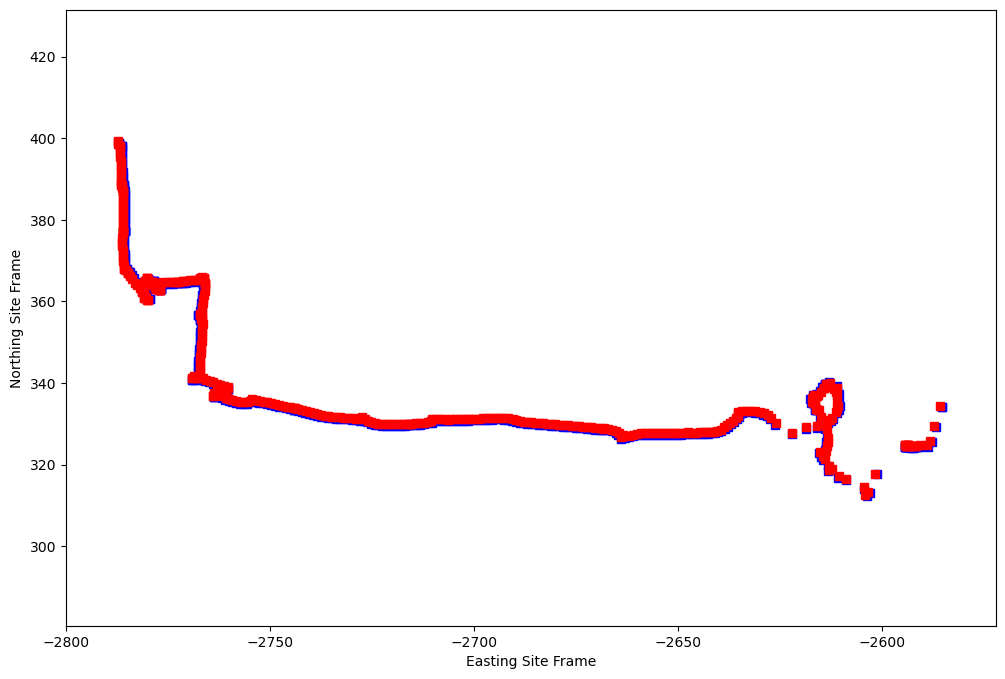

In [12]:
%run MPPP.py

# plot image and rover locations

plot_image_locations( IMG_paths, im_xyzs, rover_xyzs, rover_rots, im_azs, im_els )

## Ignore the notes below

In [6]:
# '''
# df_refs : pandas dataframe that holds reference info for each image

# data saves in the output directory as a CSV file 'df'+output+'.csv' and as a python pickle 'df'+output+'.pkl'

# '''

# df_refs = pd.DataFrame( 
#     columns = [ 
#         'sol',           # sol number or Mars day since landing is a natural way to describe images.
#         'site',          # site index for the rover's location, site 3 is the landing site
#         'drive',         # drive index is where the rover is relative to the current site frame
#         'time',          # datetime of image capture
        
#         'xyz_enu',       # postition XYZ values in meters ENU = [xEast, yNorth, zUp ] from site 3 (note: as Metashape interprets XYZ)
#         'xyz_ned',       # postition XYZ values in meters NED = [xNorth, yEast, zDown] from site 3
#         'rot_rpy',       # rotation angles in RPY = [roll, pitch, yaw] in degrees (as Metashape interprets roll-pitch-yaw)
#         'rot_ypr',       # rotation angles in YPR = [yaw, pitch, roll] in degrees 
#         'rot_opk',       # rotation angles in OPK = [omega, phi, kappa] in degrees 
        
#         'site_wy',       # waypoint site index, same as the current site if 'site_wy' == 'site' 
#         'drive_wp',      # waypoint drive index, same as the current drive if 'drive_wy' == 'drive'      
#         'xyz_wp',        # waypoint postition XYZ values in meters NED = [xNorthing, yEasting, zElevation]
#         'xyz_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorth, yEast, zDown], 'xyz_site3'=[0,0,0] if site3 is the default reference frame
#         'nee_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorthing, yEasting, zElevation]
#         'lle_site3'      # postition in [longitude, latitude, elevation] Mars global coordinates        
       
#         'cahvor',        # the CAHVOR or CAHVORE camera model in rover frame [xFront, yRight, zDown]
#         'az_site',       # site-frame azimuth pointing in degrees clockwise from the North vector 
#         'el_site',       # site-frame elevation pointing in degrees positive from the horizone
#         'az_rover',      # rover-frame azimuth pointing in degrees clockwise from the rover's forward vector
#         'el_rover',      # rover-frame elevation pointing in degrees positive from the forward-right plane       
        
#         'ref',           # string that forms the image's line in the reference file for import to software (Metashape)
#         'filename',      # file name with .IMG extension
#         'filepath',      # complete file path to image at run time
# ])


# df_refs

In [7]:
# ignore the below cells

In [8]:
# For find_offset_mode = 1

# # pos_lines  = []
# # rover_xyzs = []
# # im_xyzs    = []
# # sols       = []
# # rmcs = []
sites  = [ rmcs[i][0] for i in range(len(rmcs))[::-1] ]
drives = [ rmcs[i][1] for i in range(len(rmcs))[::-1] ]
Xs     = [ rover_xyzs[i][0] for i in range(len(rover_xyzs))[::-1] ]
Ys     = [ rover_xyzs[i][1] for i in range(len(rover_xyzs))[::-1] ]
Zs     = [ rover_xyzs[i][2] for i in range(len(rover_xyzs))[::-1] ]

table = np.stack( [sols[::-1], sites, drives, Xs, Ys, Zs], axis=1)
np.round( table, 4 )

np.savetxt( directory_output+"/offsets.csv", table, delimiter="\t")

In [9]:
# Scam flatfield

path = 'C:/Users/cornell/Mastcam-Z/ws/seitah'
pre = 'L*_0510*'

RAD_paths = [] \
          + sorted( glob.glob(  path + '/' +pre+'*R*_N*.IMG' ) ) \

RAD_paths

ims = []
for i in range(len(RAD_paths))[:]:
    
    im_image = PDS3Image.open( RAD_paths[i] ).image
    ims.append( np.float64( im_image) )
    
flat = np.mean( ims, axis=0)
for i in range(3):
    flat[:,:,i] /= np.mean( flat[700:-700,700:-700,i] )
    
plt.imshow( flat/1.5 )

C:\Users\cdt59\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cdt59\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: invalid index to scalar variable.

In [ ]:
x = np.arange(0, 2048)
y = np.arange(0, 2048)
xv, yv = np.meshgrid(x, y)

y0, x0, r0, p = [900,1000,1000,3]
dv = ( (xv-x0)**2 + (yv-y0)**2 )**(p/2)
dv /= (r0**p)*2
dv += 1

# lim = .8
# dv[ dv<lim]  =lim

dflat = flat.copy()
for i in range(3):
    dflat[:,:,i] *= dv
    
plt.imshow( dflat/2 )
plt.colorbar()

In [ ]:
dvl = np.mean( dflat[:,1000:1300], axis=1)
plt.plot(dvl)

dvl = np.mean( flat[:,1000:1300], axis=1)
plt.plot(dvl)
# flat = dflat.copy()

In [ ]:
import urllib.request, json 

'''

https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json

https://docs.google.com/spreadsheets/d/1GSNJL-e5iROCaKUC4BXL_OA8hWy8vUdfCN7levRNkZA/edit#gid=1232397498

''' 
# path =  'C:/Users/cornell/Downloads/M20_waypoints.json'
# with open( path ) as f:
#     data = json.load(f)

with urllib.request.urlopen("https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json") as url:
    data = json.loads(url.read().decode())

    
site3_E = data['features'][0]['properties']['easting']
site3_N = data['features'][0]['properties']['northing']
site3_A = data['features'][0]['properties']['elev_geoid']


for i in range(len(data['features']))[::-1]:
    
    print( data['features'][i]['properties']['sol'],'\t',
           data['features'][i]['properties']['site'], '\t',
           data['features'][i]['properties']['drive'],'\t',
           ''+'\t',''+'\t',''+'\t',
           np.round( np.float64(data['features'][i]['properties']['easting'])- np.float64(site3_E), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['northing'])- np.float64(site3_N), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A), 3),'\t',
         )